In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
import warnings as wr
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from pathlib import Path

wr.filterwarnings('ignore')

work_dir = Path.cwd().parent.parent / 'Work'
df = pd.read_csv(work_dir / "summary_test.tsv", sep ='\t')

In [10]:
delete_columns = ['id_person', 'id_test_attempt']
features = [column for column in df.columns if column not in delete_columns]
df.drop(delete_columns, axis=1)
df = df.dropna()
# 4 строки удаляет

In [ ]:
delete_columns = ['id_person', 'id_test_attempt', 'age', 'sex']
features = [column for column in df.columns if column not in delete_columns]

def split_data(
    df_dataset,
    cols,
    scaler,
    target_col='age',
    test_size=0.2,
    valid_size=0.2,
    bins=[-1, 10, 20, 30, 40, 50, 70, 85],
    labels=[0, 1, 2, 3, 4, 5, 6],
    random_state=42,
    get_valid_data=True
):
    strat_groups = pd.cut(df_dataset[target_col], bins=bins, labels=labels)

    X_train, X_test, y_train, y_test = train_test_split(
        df_dataset[cols],
        df_dataset[target_col],
        test_size=test_size,
        stratify=strat_groups,
        random_state=random_state
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train_scaled, columns=cols, index=X_train.index)
    X_test = pd.DataFrame(X_test_scaled, columns=cols, index=X_test.index)
    
    if not get_valid_data:
        return X_train, X_test, y_train, y_test
    
    valid_strat_groups = pd.cut(y_train, bins=bins, labels=labels)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train,
        y_train,
        test_size=valid_size,
        stratify=valid_strat_groups,
        random_state=random_state
    )
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test

    

scaler = MinMaxScaler()
X_train, X_valid, X_test, y_train, y_valid, y_test = split_data(df, features, scaler=scaler)  


X_train_valid = np.vstack([X_train, X_valid])
y_train_valid = np.concatenate([y_train, y_valid])

split_index = [-1] * len(X_train) + [0] * len(X_valid)
ps = PredefinedSplit(test_fold=split_index)

# grid_space = {'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
#               'weights': ['uniform', 'distance'],
#               'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev']
# }

# grid = GridSearchCV(KNeighborsRegressor(), 
#                     grid_space, 
#                     cv=ps, 
#                     scoring='neg_mean_absolute_error'
# )

# grid.fit(X_train_valid, y_train_valid)

# print("Лучшие параметры:", grid.best_params_)
# print("Лучший результат:", grid.best_score_)

# Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}, с distance - переобучение
knn = KNeighborsRegressor(metric='manhattan', n_neighbors=3, weights='uniform') #обучяем модель
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)  # используем модель на обучающей выборке
train_mae = mean_absolute_error(y_train, y_train_pred)
print("MAE при обучающей выборке:", train_mae)

y_valid_pred = knn.predict(X_valid)  # используем модель на валидационной выборке
val_mae = mean_absolute_error(y_valid, y_valid_pred)
print("MAE при валидационной выборке:", val_mae)

y_test_pred = knn.predict(X_test)  #на тестовой
test_mae = mean_absolute_error(y_test, y_test_pred)
print("MAE при тестовой выборке:", test_mae)

Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Лучший результат: -7.996990365054215
MAE при обучающей выборке: 4.614379691974305
MAE при валидационной выборке: 8.110015220700152
MAE при тестовой выборке: 7.02427301129536


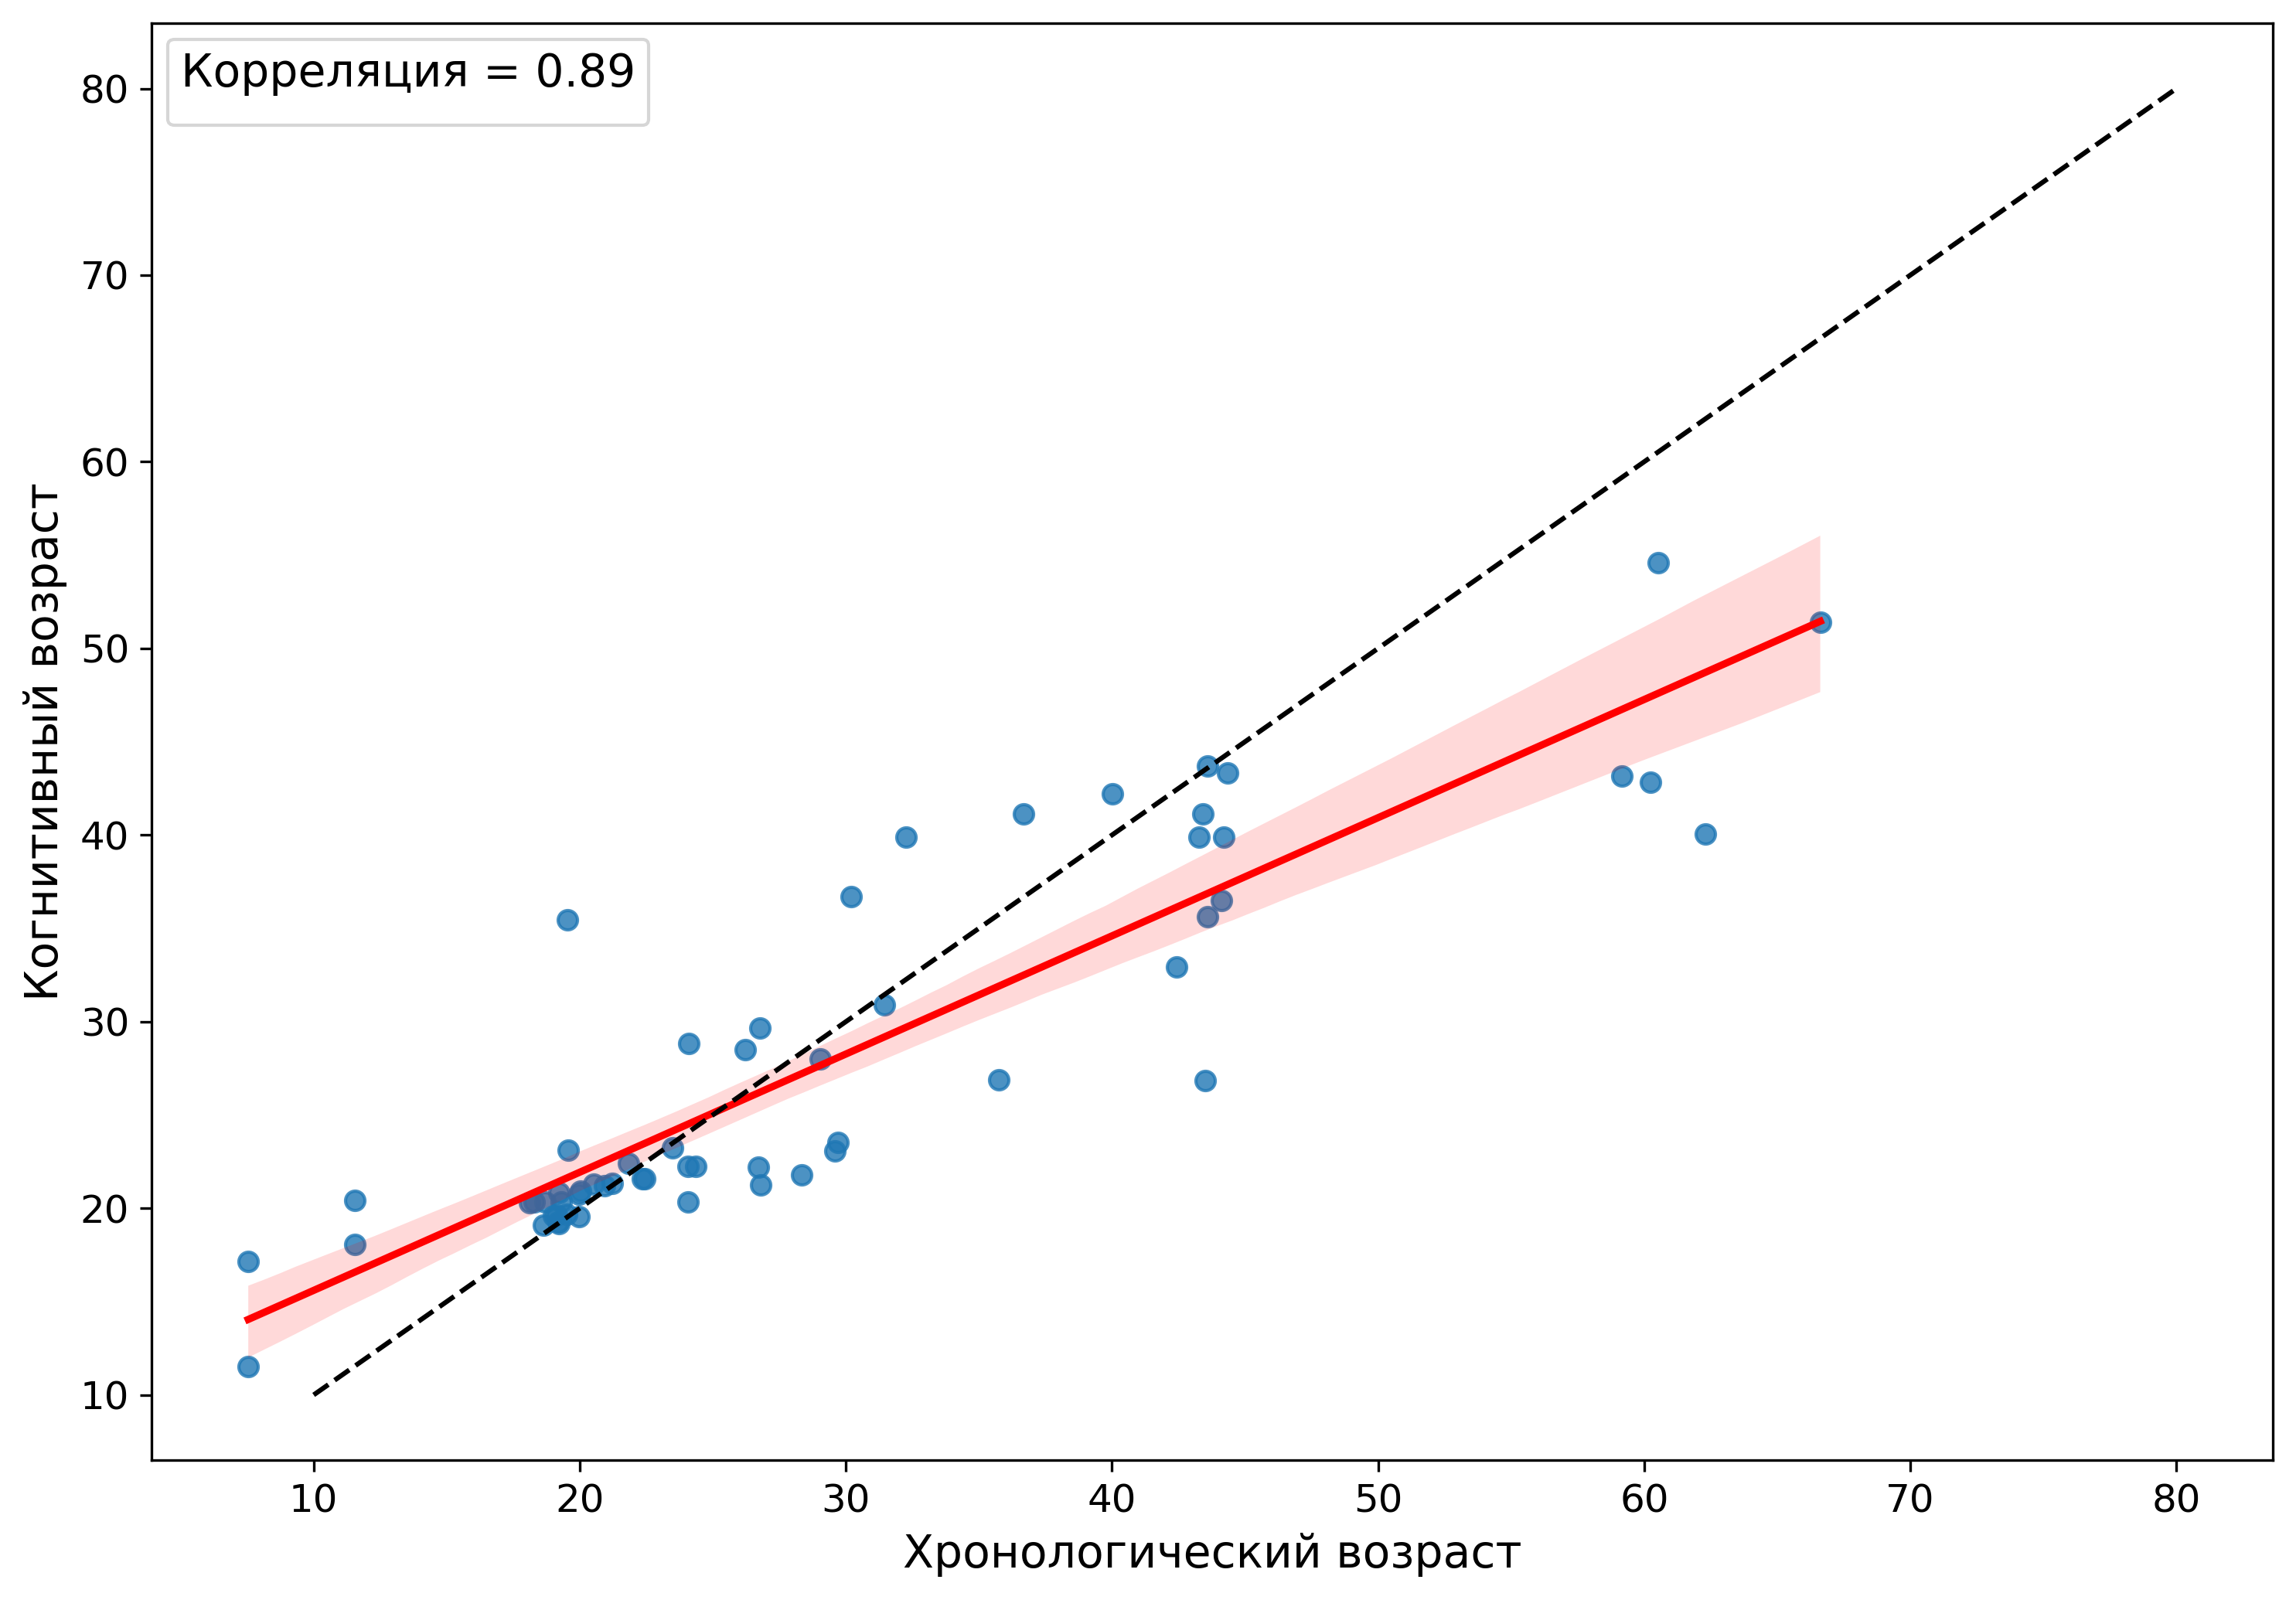

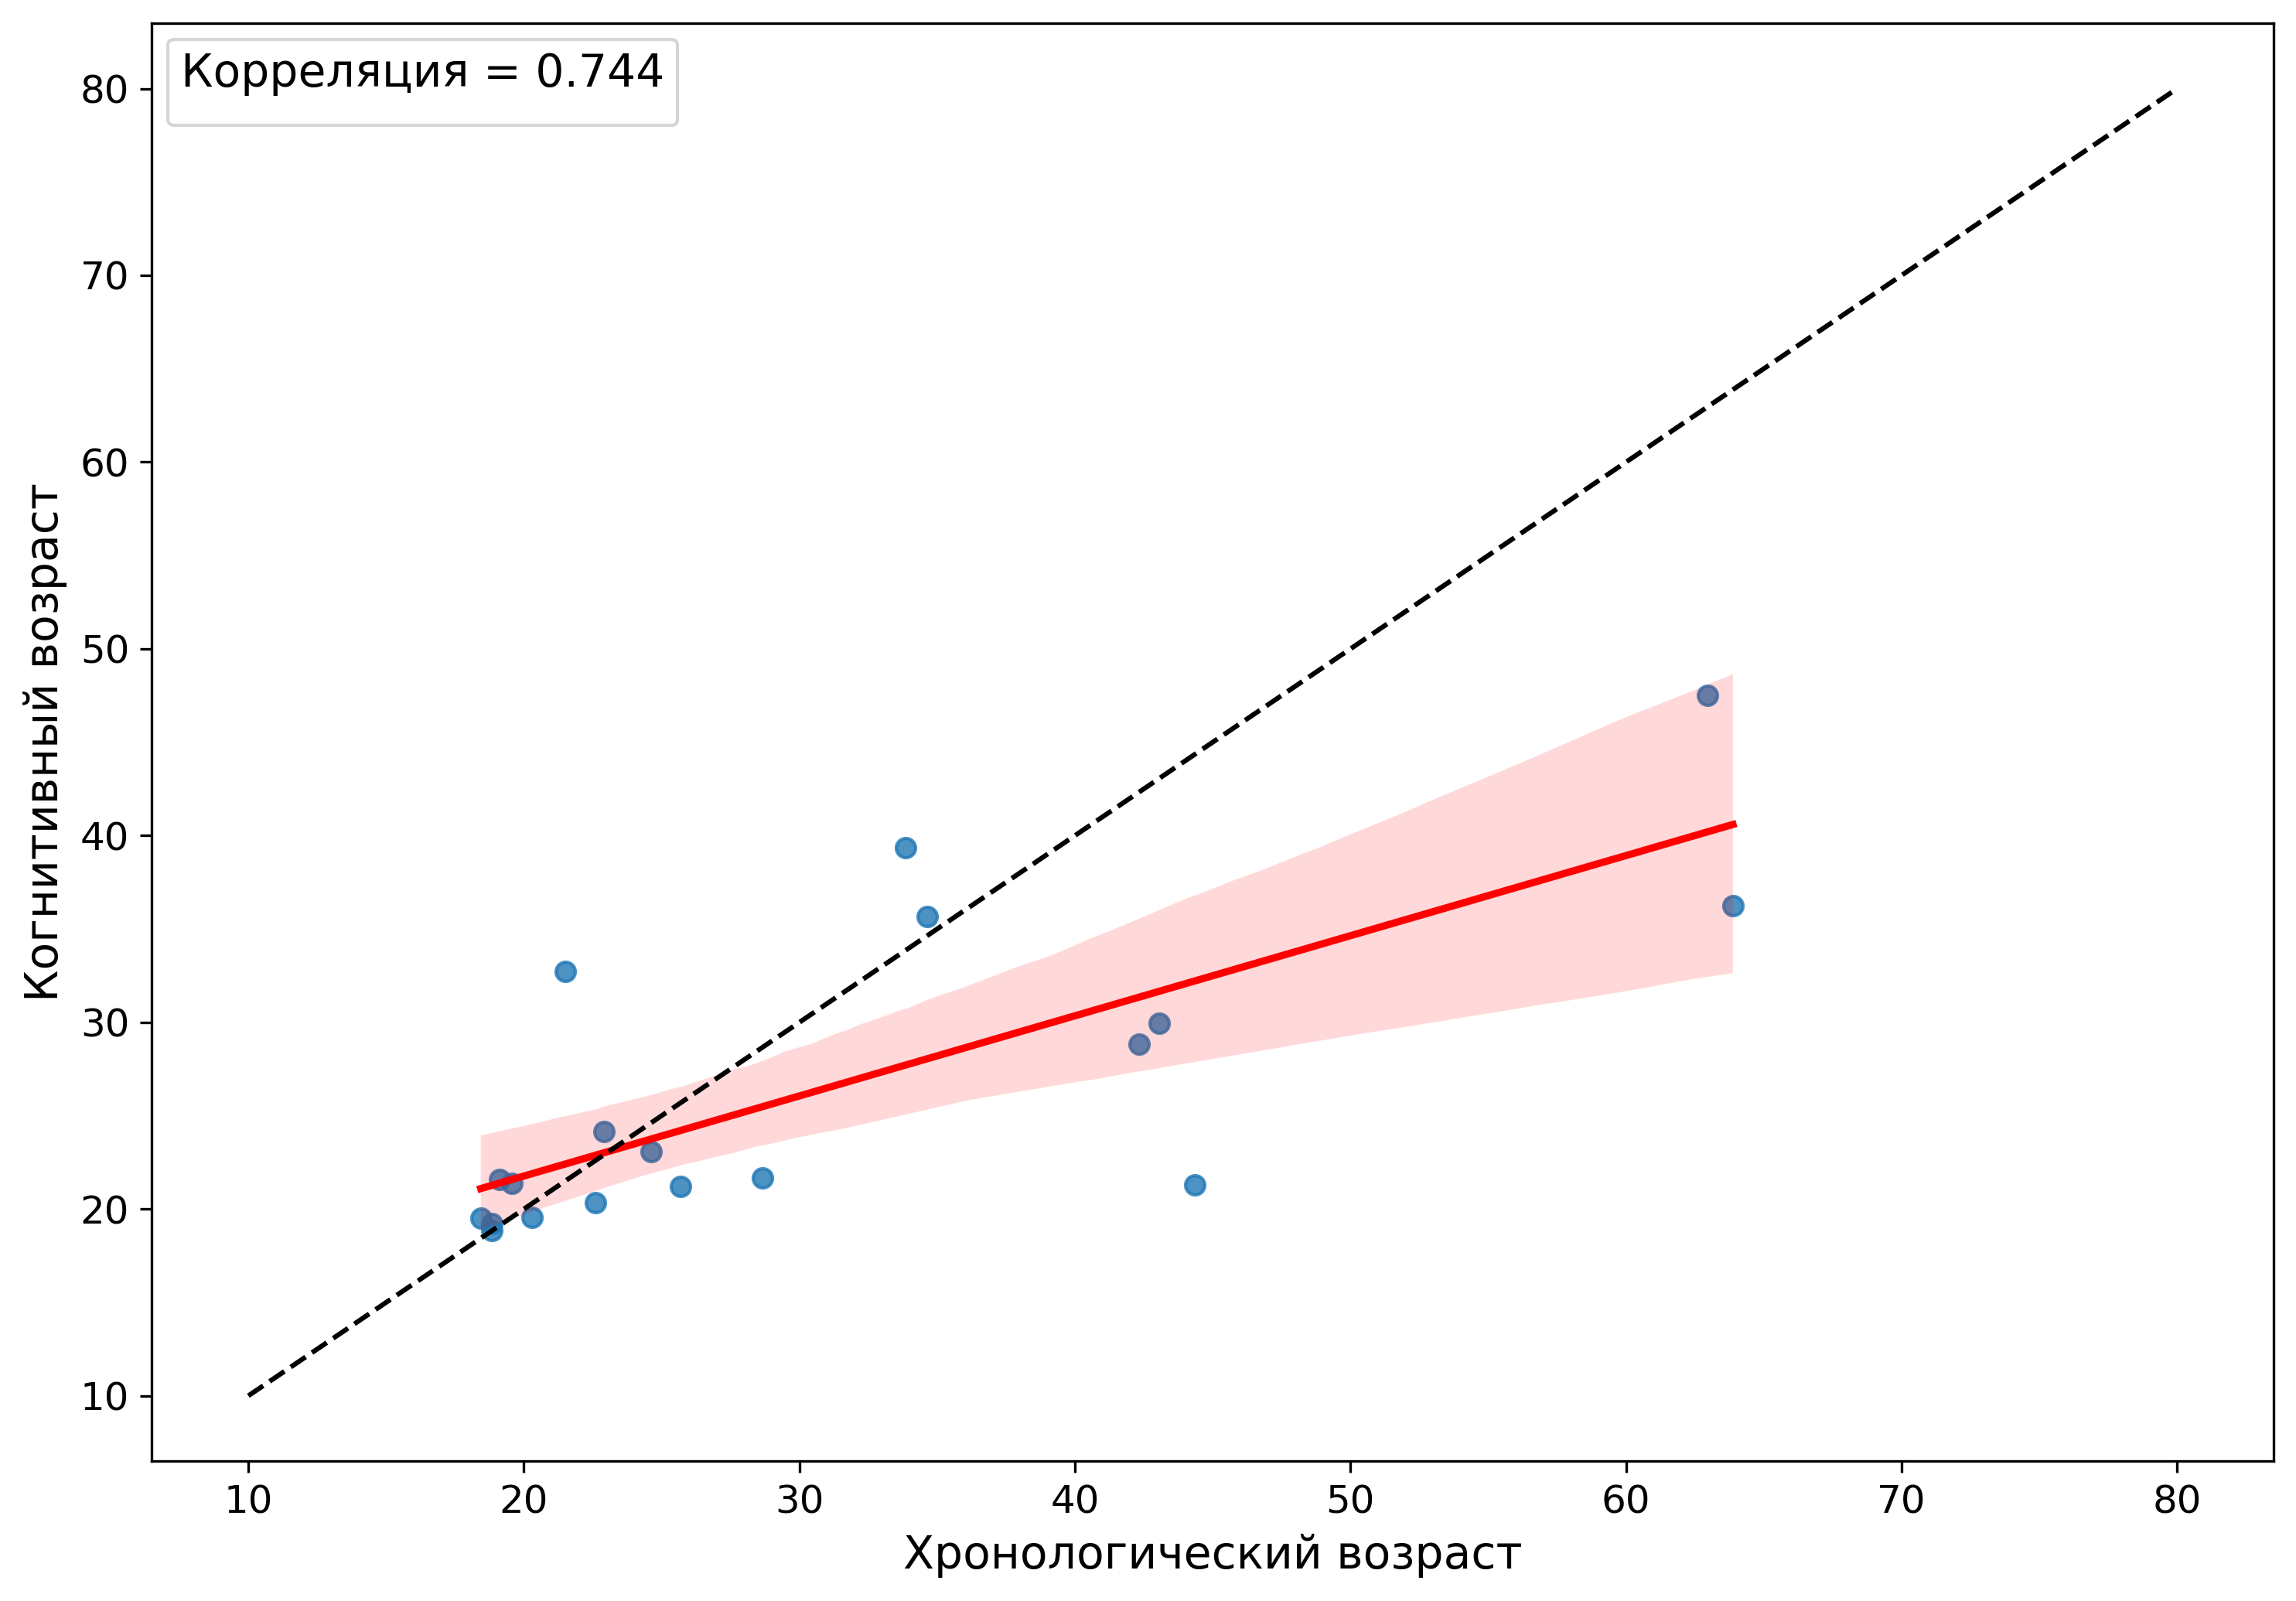

In [12]:
def scatterplot_with_ages(y1, y2, label): 
    ages_df = pd.DataFrame({
        'Хронологический возраст': y1,
        'Когнитивный возраст': y2
    })

    save_dir = work_dir / 'ModelsR' 
    save_dir.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 7), dpi=300)

    r1, p = pearsonr(y1, y2)
    r2, p = spearmanr(abs(y2 - y1), y1)
    sns.regplot(
        data=ages_df,
        x='Хронологический возраст',
        y='Когнитивный возраст',
        line_kws={'color': 'red'}
    )
    
    plt.legend(title=f'Корреляция = {round(r1, 3)}', loc='upper left', title_fontsize=14)
    plt.plot([10, 80], [10, 80], 'k--') 
    plt.xlabel('Хронологический возраст', fontsize = 14)
    plt.ylabel('Когнитивный возраст', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig(save_dir / label, bbox_inches='tight')
    plt.show()


scatterplot_with_ages(y_train, y_train_pred, label='KNN_app_train')
scatterplot_with_ages(y_test, y_test_pred, label='KNN_app_test')